In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 把数据集放到5242文件夹里
import os
import sys
sys.path.append("/content/drive/MyDrive/CS5242/")
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from sklearn.metrics import f1_score, accuracy_score
from IPython import display
import time
import sklearn.metrics
import json
import collections
import numpy as np
import pandas as pd
from transformers.optimization import get_cosine_schedule_with_warmup
import math
import copy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split


## Utils

In [7]:
class Args(object):
    def __init__(self):
        super().__init__()
        self.optimizer = 'adamw'
        self.batch_size = 16
        self.num_epochs = 10
        self.lr = 1e-3
        self.weight_decay = 1e-4
        self.lr_period = 4
        self.lr_decay = 0.8
        self.dropout = 0.1
        self.embedding_dim = 300
        self.hidden_dim = 300
        self.num_class = 3
        self.num_aspect = 6
        self.max_seq_len = 500
        self.num_warmup_steps = 200
        self.pt_path = "/content/drive/MyDrive/CS5242/ckpt"
        self.img_path = "/content/drive/MyDrive/CS5242/images"
        self.learning_rates = []
        self.monitor = 'loss'
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

    def save(self, output_dir, fname):
        plt.savefig(os.path.join(output_dir, fname), dpi=600)

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def accuracy(y_pred, y):
    """Compute the number of correct predictions.
    Defined in :numref:`sec_utils`"""
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = torch.argmax(y_pred, axis=1)
    cmp = (y_pred.type(y.dtype)) == y
    return float(torch.sum(cmp.type(y.dtype)))

def download_model(model_name,cache_dir):
  if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
  tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
  model = AutoModel.from_pretrained(model_name, cache_dir=cache_dir)
  total, trainable = count_parameters(model)
  print(f"Total Parameters: {total:,}, Trainable: {trainable:,}")
  print(model)

def evaluate_loss_and_acc_gpu(net, data_iter, loss=None, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    if loss:
        metric = Accumulator(3)
    else:
        metric = Accumulator(2)

    with torch.no_grad():
        for batch in data_iter:
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)
            y = batch['label']
            y_pred = net(**batch)
            if loss:
                metric.add(loss(y_pred, y).sum(), accuracy(y_pred, y), torch.numel(y))
            else:
                metric.add(accuracy(y_pred, y), torch.numel(y))
    return (metric[0] / metric[2], metric[1] / metric[2]) if loss else metric[0] / metric[1]

def train_batch(net, batch, loss, trainer, devices):
    """Train for a minibatch """
    if isinstance(batch, dict):
        for k, v in batch.items():
            batch[k] = batch[k].to(devices[0])
    else:
        batch = batch.to(devices[0])
    y = batch['label']
    net.train()
    trainer.zero_grad()
    pred = net(**batch)
    l = loss(pred, y)
    l.mean().backward()
    trainer.step()
    train_loss_sum = l.sum().item()
    train_acc_sum = accuracy(pred, y)
    args.learning_rates.append(trainer.param_groups[0]["lr"])
    return train_loss_sum, train_acc_sum

def train_transformer(net, train_iter, valid_iter, num_epochs,
                      optimizer, lr, wd, num_warmup_steps,
                      devices, task_name):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)

    model_name = str(net.__class__.__name__)
    scheduler = get_cosine_schedule_with_warmup(trainer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epochs*len(train_iter))

    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))

    if args.monitor == 'loss':
        monitor_val = math.inf
    else:
        monitor_val = -math.inf
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, batch in enumerate(tqdm(train_iter)):
            timer.start()
            labels = batch['label']
            output = train_batch(net, batch, loss, trainer, devices)
            scheduler.step()
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None, None))

        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if args.monitor == 'loss':
                if valid_loss < monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_loss
            else:
                if valid_acc > monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_acc{valid_acc :.2f}.pt"
                    best_model_state = copy.deepcopy(net.state_dict())
                    monitor_val = valid_acc


    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join(args.pt_path, filename)
    torch.save(best_model_state, args.pt_path)
    animator.save(args.img_path, filename + f"-train_loss{metric[0] / metric[2]:.2f}.png")

def test(net, data_iter, output_dir=None, device=None):
    net.eval()
    full_logits=[]
    full_label_ids=[]
    for i, batch in tqdm(enumerate(data_iter)):
        with torch.no_grad():
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)

            logits = net(**batch)
            logits = logits.detach().cpu().numpy()
            y = batch['label'].cpu().numpy()

            full_logits.extend(logits.tolist())
            full_label_ids.extend(y.tolist())

    y_pred = [np.argmax(logit) for logit in full_logits]
    y_true = full_label_ids
    f1 =sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    acc =sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"test on final epoch -- acc: {acc*100 :.2f}, f1-macro: {f1*100 :.2f}")
    if output_dir:
        output_eval_json = os.path.join(output_dir, str(net.__class__.__name__) + "_predictions.json")
        with open(output_eval_json, "w") as fw:
            json.dump({"logits": full_logits, "label_ids": full_label_ids}, fw)

def test_on_checkpoint(net, file_path, data_iter, output_dir=None, device=None):
    state_dict = torch.load(file_path, map_location=device)
    net.load_state_dict(state_dict)
    net.to(device)
    net.eval()
    full_logits=[]
    full_label_ids=[]
    full_aspect_ids = []
    for i, batch in enumerate(data_iter):
        with torch.no_grad():
            if isinstance(batch, dict):
                for k, v in batch.items():
                    batch[k] = batch[k].to(device)
            else:
                batch = batch.to(device)

            logits = net(**batch)
            logits = logits.detach().cpu().numpy()
            y = batch['label'].cpu().numpy()

            full_logits.extend(logits.tolist())
            full_label_ids.extend(y.tolist())


    y_pred = [np.argmax(logit) for logit in full_logits]
    y_true = full_label_ids
    f1 =sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    acc =sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"test on {file_path} -- acc: {acc*100 :.2f}, f1-macro: {f1*100 :.2f}")
    if output_dir:
        output_eval_json = os.path.join(output_dir, str(net.__class__.__name__) + "_predictions.json")
        with open(output_eval_json, "w") as fw:
            json.dump({"logits": full_logits, "label_ids": full_label_ids}, fw)


## 4. BGE Model

In [8]:
class BGEProcessor(object):
    def __init__(self, data_dir, data_name):
        self.data_dir = data_dir
        self.data_name = data_name

    def get_examples(self):
        """Read data from json file.
        Args:
            data_dir (string):
                Path.
            mode (string):
                Indicate train/dev/test.
        Returns:
            examples for different modes.
        """
        return self._create_examples(self._read_json(os.path.join(self.data_dir, self.data_name)))

    def get_labels(self):
        """Return labels for specific dataset"""
        return ["negative", "neutral", "positive"]

    def _create_examples(self, datas):
        """Creates examples for the training and dev sets."""
        examples = []
        for idx,data in enumerate(datas):
            data['label'] = int(data["label"])
            examples.append(data)
        return examples

    def _read_json(self, input_file):
        """Reads a json file for tasks in sentiment analysis."""
        datas = []
        with open(input_file, 'r', encoding='utf-8') as f:
          for line in f:
              obj = json.loads(line)
              datas.append(obj)
        return datas

class SingleTowerBGEDataset(Dataset):
    """Build dataset and convert examples to features"""
    def __init__(self, model_name, cache_dir, samples):
        self.model_name = model_name
        self.samples = samples
        print(len(self.samples))
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        self.convert_data_to_features()

    def convert_data_to_features(self):
        """convert examples to features"""
        label_map = {0: 0, 1: 1, 2: 2}

        output = []
        for (i, sample) in tqdm(enumerate(self.samples)):
            feature = {}
            query = sample['query']
            document = sample['title']
            inputs = self.tokenizer(query,
                                    document,
                                    return_tensors="pt",
                                    padding=True,
                                    truncation=True)

            input_ids = inputs["input_ids"][0]
            token_type_ids  = inputs["token_type_ids"][0]
            attention_mask = inputs["attention_mask"][0]
            label_id = label_map[sample['label']]
            feature = {
                "input_ids": input_ids,
                "token_type_ids": token_type_ids,
                "attention_mask": attention_mask,
                "label_id": label_id
            }
            output += [feature]
        self.data = output

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def build_bge_collate_fn(tokenizer):
    def collate_fn(batch):
        input_ids = [item['input_ids'] for item in batch]
        attention_mask = [item['attention_mask'] for item in batch]
        token_type_ids = [item['token_type_ids'] for item in batch]
        label_ids = torch.tensor([item['label_id'] for item in batch])

        padded = tokenizer.pad(
            {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "token_type_ids": token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        return {
            "input_ids": padded["input_ids"],
            "attention_mask": padded["attention_mask"],
            "token_type_ids": padded["token_type_ids"],
            "label": label_ids
        }
    return collate_fn

class DualTowerBGEDataset(Dataset):
    """Build dataset for dual tower model and convert examples to features separately"""
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        self.samples = samples
        self.data = self.convert_data_to_features(samples)

    def convert_data_to_features(self, samples):
        label_map = {0: 0, 1: 1, 2: 2}
        features = []

        for sample in tqdm(samples, desc="Converting data"):
            query = sample['query']
            document = sample['title']
            label = label_map[sample['label']]

            query_inputs = self.tokenizer(query,
                                          return_tensors="pt",
                                          padding=True,
                                          truncation=True)
            doc_inputs = self.tokenizer(  document,
                                          return_tensors="pt",
                                          padding=True,
                                          truncation=True)

            feature = {
                "query_input_ids": query_inputs["input_ids"].squeeze(0),
                "query_attention_mask": query_inputs["attention_mask"].squeeze(0),
                "query_token_type_ids": query_inputs["token_type_ids"].squeeze(0),

                "doc_input_ids": doc_inputs["input_ids"].squeeze(0),
                "doc_attention_mask": doc_inputs["attention_mask"].squeeze(0),
                "doc_token_type_ids": doc_inputs["token_type_ids"].squeeze(0),

                "label": label
            }
            features.append(feature)
        return features

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

def build_dual_bge_collate_fn(tokenizer):
    def collate_fn(batch):
        query_input_ids = [item['query_input_ids'] for item in batch]
        query_attention_mask = [item['query_attention_mask'] for item in batch]
        query_token_type_ids = [item['query_token_type_ids'] for item in batch]

        doc_input_ids = [item['doc_input_ids'] for item in batch]
        doc_attention_mask = [item['doc_attention_mask'] for item in batch]
        doc_token_type_ids = [item['doc_token_type_ids'] for item in batch]

        label_ids = torch.tensor([item['label'] for item in batch])

        # Padding query
        query_batch = tokenizer.pad(
            {
                "input_ids": query_input_ids,
                "attention_mask": query_attention_mask,
                "token_type_ids": query_token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        # Padding document
        doc_batch = tokenizer.pad(
            {
                "input_ids": doc_input_ids,
                "attention_mask": doc_attention_mask,
                "token_type_ids": doc_token_type_ids,
            },
            return_tensors="pt",
            padding=True
        )

        return {
            "query_input_ids": query_batch["input_ids"],
            "query_attention_mask": query_batch["attention_mask"],
            "query_token_type_ids": query_batch["token_type_ids"],
            "doc_input_ids": doc_batch["input_ids"],
            "doc_attention_mask": doc_batch["attention_mask"],
            "doc_token_type_ids": doc_batch["token_type_ids"],
            "label": label_ids
        }

    return collate_fn

### 4.1 SingleTowerBGE Model

In [ ]:
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "BAAI/bge-base-zh-v1.5" ; cache_dir = "/content/drive/MyDrive/CS5242/bge-base-zh-v1.5"
test_data_name = "test_public.json" ; train_data_name = "train.json"
task_name = "SingleTowerBGE"
args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
download_model(model_name,cache_dir)

Total Parameters: 102,267,648, Trainable: 102,267,648
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:18000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:2000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

In [ ]:
train_data = SingleTowerBGEDataset(model_name, cache_dir,train_examples)
dev_data = SingleTowerBGEDataset(model_name, cache_dir,dev_examples)
test_data = SingleTowerBGEDataset(model_name, cache_dir,test_examples)

16000


16000it [00:05, 2688.04it/s]


2000


2000it [00:01, 1955.51it/s]


2000


2000it [00:00, 2373.35it/s]


In [ ]:
class SingleTowerBGE(nn.Module):
    """ Transformer encoder"""
    def __init__(self, model_name,cache_dir,output_dim):
        super().__init__()
        self.model_name = model_name
        self.cache_dir = cache_dir
        self.bge = AutoModel.from_pretrained(self.model_name,cache_dir=self.cache_dir)
        self.d_model = self.bge.config.hidden_size
        self.clf = nn.Sequential(
            nn.Linear(self.d_model, self.d_model),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(self.d_model, output_dim),
        )

    def forward(self, input_ids, attention_mask, token_type_ids, **kwarg):
        outputs = self.bge(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
        ).last_hidden_state
        logits = self.clf(outputs[:,0,:])
        return logits

In [ ]:
train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn=build_bge_collate_fn(
                              AutoTokenizer.from_pretrained(
                                  model_name,
                                  cache_dir = cache_dir)),
                       shuffle=False)

In [ ]:
net = SingleTowerBGE(model_name,cache_dir,args.num_class).to(devices[0])

train loss 0.224, train acc 0.923, valid loss 1.012, valid acc 0.647
77.4 examples/sec on [device(type='cuda')]


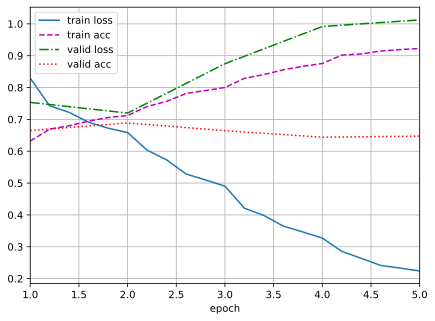

In [ ]:
train_transformer(net,
                  train_iter,
                  dev_iter,
                  args.num_epochs,
                  args.optimizer,
                  args.lr,
                  args.weight_decay,
                  args.num_warmup_steps,
                  devices,
                  task_name)

In [ ]:
test(net,test_iter,None,device = devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, None, device=devices[0])

0it [00:00, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
32it [00:09,  3.47it/s]


test on final epoch -- acc: 65.80, f1-macro: 56.21
test on /content/drive/MyDrive/CS5242/ckpt/SingleTowerBGE-epoch1-val_acc0.69.pt -- acc: 70.25, f1-macro: 50.29


### 4.2 DualTowerBGE

In [ ]:
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "BAAI/bge-small-zh-v1.5" ; cache_dir = "/content/drive/MyDrive/CS5242/bge-small-zh-v1.5"
test_data_name = "test_public.json" ; train_data_name = "train.json"
args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
task_name = "DualTowerBGE"
download_model(model_name,cache_dir)

Total Parameters: 23,953,920, Trainable: 23,953,920
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 512, padding_idx=0)
    (position_embeddings): Embedding(512, 512)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-3): 4 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
 

In [ ]:
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:18000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:2000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

In [ ]:
train_data = DualTowerBGEDataset(model_name, cache_dir,train_examples)
dev_data = DualTowerBGEDataset(model_name, cache_dir,dev_examples)
test_data = DualTowerBGEDataset(model_name, cache_dir,test_examples)

Converting data: 100%|██████████| 2000/2000 [00:00<00:00, 2631.17it/s]


In [ ]:
class DualTowerBGE(nn.Module):
    """ Dual Tower Transformer Encoder """
    def __init__(self, model_name, cache_dir, output_dim):
        super().__init__()
        self.model_name = model_name
        self.cache_dir = cache_dir
        self.query_encoder = AutoModel.from_pretrained(self.model_name, cache_dir=self.cache_dir)
        self.doc_encoder = AutoModel.from_pretrained(self.model_name, cache_dir=self.cache_dir)
        self.d_model = self.query_encoder.config.hidden_size
        self.clf = nn.Sequential(
            nn.Linear(self.d_model * 2, self.d_model),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(self.d_model, output_dim),
        )

    def forward(self, query_input_ids,
                      query_attention_mask,
                      query_token_type_ids,
                      doc_input_ids,
                      doc_attention_mask,
                      doc_token_type_ids,
                      **kwargs):
        '''
        query_inputs: dict, doc_inputs: dict
        Including input_ids, attention_mask, token_type_ids
        '''
        query_inputs = {"input_ids":query_input_ids,
                        "attention_mask":query_attention_mask,
                        "token_type_ids":query_token_type_ids}
        doc_inputs   = {"input_ids":doc_input_ids,
                        "attention_mask":doc_attention_mask,
                        "token_type_ids":doc_token_type_ids}
        query_output = self.query_encoder(**query_inputs).last_hidden_state[:, 0, :]  # [CLS]
        doc_output = self.doc_encoder(**doc_inputs).last_hidden_state[:, 0, :]        # [CLS]
        concat = torch.cat([query_output, doc_output], dim=-1)  # [batch, 2*d_model]
        logits = self.clf(concat)
        return logits


In [ ]:
train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

In [ ]:
net = DualTowerBGE(model_name,cache_dir,args.num_class).to(devices[0])

train loss 0.510, train acc 0.793, valid loss 0.876, valid acc 0.646
381.3 examples/sec on [device(type='cuda')]


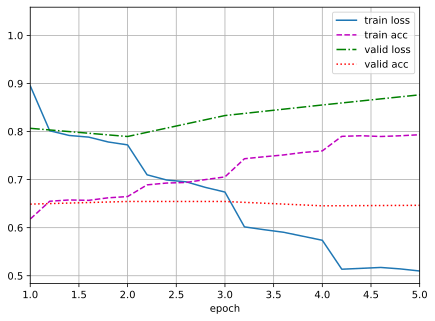

In [ ]:
train_transformer(net,
                  train_iter,
                  dev_iter,
                  args.num_epochs,
                  args.optimizer,
                  args.lr,
                  args.weight_decay,
                  args.num_warmup_steps,
                  devices,
                  task_name)

In [ ]:
test(net,test_iter,None,device = devices[0])
test_on_checkpoint(net, args.pt_path, test_iter, None, device=devices[0])

32it [00:01, 16.55it/s]


test on final epoch -- acc: 66.70, f1-macro: 44.63
test on /content/drive/MyDrive/CS5242/ckpt/DualTowerBGE-epoch1-val_acc0.65.pt -- acc: 66.70, f1-macro: 44.63


### 4.3 Knowledge Distillation

In [ ]:
student_model_name = "BAAI/bge-small-zh-v1.5"
student_cache_dir = "/content/drive/MyDrive/CS5242/bge-small-zh-v1.5"

teacher_model_name = "BAAI/bge-base-zh-v1.5"
teacher_cache_dir = "/content/drive/MyDrive/CS5242/bge-base-zh-v1.5"

data_dir = "/content/drive/MyDrive/CS5242/"
test_data_name = "test_public.json"
train_data_name = "train.json"

task_name = "NDDualTowerBGE"
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]

args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'

models = os.listdir("/content/drive/MyDrive/CS5242/ckpt/")
for model in models:
  if "SingleTowerBGE" in model:
    teacher_ckpt_path = os.path.join("/content/drive/MyDrive/CS5242/ckpt/",model)
    break

In [ ]:
teacher_net = SingleTowerBGE(teacher_model_name, teacher_cache_dir, args.num_class)
teacher_net.load_state_dict(torch.load(teacher_ckpt_path))
teacher_net.to(devices[0])
teacher_net.eval()
for param in teacher_net.parameters():
    param.requires_grad_(False)

student_net = DualTowerBGE(student_model_name, student_cache_dir, args.num_class)
student_net.to(devices[0])

train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:18000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:2000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

student_train_data = DualTowerBGEDataset(student_model_name, student_cache_dir,train_examples)
student_dev_data = DualTowerBGEDataset(student_model_name, student_cache_dir,dev_examples)
student_test_data = DualTowerBGEDataset(student_model_name, student_cache_dir,test_examples)

teacher_train_data = SingleTowerBGEDataset(teacher_model_name, teacher_cache_dir, train_examples)

student_train_iter = DataLoader(dataset=student_train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
student_dev_iter = DataLoader(dataset=student_dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
student_test_iter = DataLoader(dataset=student_test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_dual_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)
teacher_train_iter = DataLoader(dataset=teacher_train_data,
                       batch_size=args.batch_size,
                       collate_fn = build_bge_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

Converting data: 100%|██████████| 2000/2000 [00:01<00:00, 1664.82it/s]


16000


16000it [00:04, 3299.78it/s]


In [ ]:
def distillation_loss(student_logits, teacher_logits, labels, T=2.0, alpha=0.5):
    soft_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1)
    ) * (T * T)
    hard_loss = F.cross_entropy(student_logits, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

def train_ND_batch(teacher_net, teacher_batch, student_net, student_batch, loss_fn, trainer, devices):
    teacher_net.eval()
    student_net.train()

    teacher_batch = {k: v.to(devices[0]) for k, v in teacher_batch.items()}
    student_batch = {k: v.to(devices[0]) for k, v in student_batch.items()}
    labels = student_batch['label']

    with torch.no_grad():
        teacher_logits = teacher_net(**teacher_batch)

    student_logits = student_net(**student_batch)

    loss = loss_fn(student_logits, teacher_logits, labels)
    trainer.zero_grad()
    loss.backward()
    trainer.step()
    args.learning_rates.append(trainer.param_groups[0]["lr"])

    return loss.item() * labels.shape[0], accuracy(student_logits, labels)

def train_ND(teacher_net,
             student_net,
             teacher_train_iter,
             student_train_iter,
             valid_iter,
             num_epochs,
             optimizer,
             lr,
             wd,
             num_warmup_steps,
             devices,
             task_name):
    if optimizer == 'sgd':
        trainer = torch.optim.SGD(student_net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    elif optimizer == 'adam':
        trainer = torch.optim.Adam(student_net.parameters(), lr=lr, weight_decay=wd)
    elif optimizer == 'adamw':
        trainer = torch.optim.AdamW(student_net.parameters(), lr=lr, weight_decay=wd)

    model_name = str(net.__class__.__name__)
    scheduler = get_cosine_schedule_with_warmup(trainer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epochs*len(student_train_iter))

    loss = nn.CrossEntropyLoss(reduction="none")
    timer = Timer()
    num_batches = len(train_iter)
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend += ['valid loss', 'valid acc']
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(7, 5))

    if args.monitor == 'loss':
        monitor_val = math.inf
    else:
        monitor_val = -math.inf
    for epoch in range(num_epochs):
        net.train()
        metric = Accumulator(4)
        for i, (teacher_batch, student_batch) in enumerate(tqdm(zip(teacher_train_iter, student_train_iter))):
            output = train_ND_batch(teacher_net,
                                    teacher_batch,
                                    student_net,
                                    student_batch,
                                    distillation_loss,
                                    trainer,
                                    devices)
            timer.start()
            labels = student_batch['label']
            scheduler.step()
            metric.add(output[0], output[1], labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2]  , metric[1] / metric[2], None, None))

        if valid_iter is not None:
            valid_loss, valid_acc = evaluate_loss_and_acc_gpu(student_net, valid_iter, loss, devices[0])
            animator.add(epoch + 1, (None, None, valid_loss, valid_acc))
            if args.monitor == 'loss':
                if valid_loss < monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                    best_model_state = copy.deepcopy(student_net.state_dict())
                    monitor_val = valid_loss
            else:
                if valid_acc > monitor_val:
                    filename = task_name + f"-epoch{epoch}-val_acc{valid_acc :.2f}.pt"
                    best_model_state = copy.deepcopy(student_net.state_dict())
                    monitor_val = valid_acc


    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
        measures += f', valid acc  {valid_acc: .3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    args.pt_path = os.path.join(args.pt_path, filename)
    torch.save(best_model_state, args.pt_path)
    animator.save(args.img_path, filename + f"-train_loss{metric[0] / metric[2]:.2f}.png")

train loss 0.377, train acc 0.776, valid loss 0.837, valid acc   0.657
1451347.7 examples/sec on [device(type='cuda')]


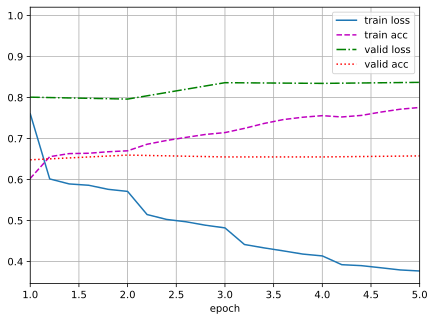

In [ ]:
train_ND(
          teacher_net,
          student_net,
          teacher_train_iter,
          student_train_iter,
          student_dev_iter,
          args.num_epochs,
          args.optimizer,
          args.lr,
          args.weight_decay,
          args.num_warmup_steps,
          devices,
          task_name)

In [ ]:
test(student_net,test_iter,None,device = devices[0])
test_on_checkpoint(student_net, args.pt_path, test_iter, None, device=devices[0])

32it [00:01, 16.77it/s]


test on final epoch -- acc: 64.30, f1-macro: 49.85
test on /content/drive/MyDrive/CS5242/ckpt/NDDualTowerBGE-epoch1-val_acc0.66.pt -- acc: 65.40, f1-macro: 48.52


## LLM

In [9]:
data_dir = "/content/drive/MyDrive/CS5242/"
model_name = "Qwen/Qwen2.5-0.5B"
cache_dir = "/content/drive/MyDrive/CS5242/Qwen2.5-0.5B"
test_data_name = "test_public.json"
train_data_name = "train.json"

args = Args()
args.lr = 3e-5
args.num_epochs=5
args.batch_size=64
args.monitor = 'accuracy'
devices = [torch.device("cuda" if torch.cuda.is_available() else "cpu")]
task_name = "Relevance with LLM"
download_model(model_name,cache_dir)

Total Parameters: 494,032,768, Trainable: 494,032,768
Qwen2Model(
  (embed_tokens): Embedding(151936, 896)
  (layers): ModuleList(
    (0-23): 24 x Qwen2DecoderLayer(
      (self_attn): Qwen2Attention(
        (q_proj): Linear(in_features=896, out_features=896, bias=True)
        (k_proj): Linear(in_features=896, out_features=128, bias=True)
        (v_proj): Linear(in_features=896, out_features=128, bias=True)
        (o_proj): Linear(in_features=896, out_features=896, bias=False)
      )
      (mlp): Qwen2MLP(
        (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
        (up_proj): Linear(in_features=896, out_features=4864, bias=False)
        (down_proj): Linear(in_features=4864, out_features=896, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
    )
  )
  (norm): Qwen2RMSNorm((896,), eps=1e-06)
  (rotary_emb): Qwen2RotaryEmbedding()
)


In [ ]:
class Qwen2LLMDataset(Dataset):
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, cache_dir=cache_dir, trust_remote_code=True
        )
        self.samples = samples
        self.convert_data_to_features()

    def convert_data_to_features(self):
        self.data = []
        system_prompt = "你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。"
        for sample in tqdm(self.samples, desc="Preparing ChatML prompts"):
            query = sample['query']
            document = sample['title']
            label = str(sample['label'])  # e.g. "0","1","2"
            messages = [
                {"role": "system",    "content": system_prompt},
                {"role": "user",      "content":
                    f"查询内容：{query}\n"
                    f"文档片段：{document}\n"
                    "请根据相关性打分，评分范围为 0 到 2：\n"
                    "0：无关\n1：一般相关\n2：相关\n"
                    "你的回答（仅填写数字）："},
                {"role": "assistant", "content": label}
            ]
            # 先拼 prompt，再 tokenize
            prompt = self.tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=False,
                tokenize=False
            )
            encoded = self.tokenizer(
                prompt,
                truncation=True,
                padding=False,
                return_tensors=None
            )
            input_ids = encoded['input_ids']
            # 只有最后 3 个 token 作为 label，其它位置都为 -100
            label_ids = input_ids[-3:]
            labels = [-100] * (len(input_ids) - 3) + label_ids

            self.data.append({
                "input_ids": input_ids,
                "attention_mask": encoded['attention_mask'],
                "labels": labels
            })

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

def build_qwen2_collate_fn(tokenizer):
    def collate_fn(batch):
        # 把 list-of-dicts 拆成三个 list-of-lists
        input_ids_list     = [torch.tensor(ex["input_ids"],     dtype=torch.long) for ex in batch]
        attention_list     = [torch.tensor(ex["attention_mask"], dtype=torch.long) for ex in batch]
        labels_list        = [torch.tensor(ex["labels"],        dtype=torch.long) for ex in batch]
        from torch.nn.utils.rnn import pad_sequence

        # 手动 pad_sequence
        input_ids_padded      = pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_padded      = pad_sequence(attention_list, batch_first=True, padding_value=0)
        labels_padded         = pad_sequence(labels_list, batch_first=True, padding_value=-100)

        return {
            "input_ids":      input_ids_padded,
            "attention_mask": attention_padded,
            "labels":         labels_padded,
        }
    return collate_fn

class Qwen2LLMTestDataset(Dataset):
    def __init__(self, model_name, cache_dir, samples):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, cache_dir=cache_dir, trust_remote_code=True
        )
        self.samples = samples
        self.convert_data_to_features()

    def convert_data_to_features(self):
        self.data = []
        system_prompt = "你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。"
        for sample in tqdm(self.samples, desc="Preparing ChatML prompts"):
            query = sample['query']
            document = sample['title']
            label = str(sample['label'])  # e.g. "0","1","2"
            messages = [
                {"role": "system",    "content": system_prompt},
                {"role": "user",      "content":
                    f"查询内容：{query}\n"
                    f"文档片段：{document}\n"
                    "请根据相关性打分，评分范围为 0 到 2：\n"
                    "0：无关\n1：一般相关\n2：相关\n"
                    "你的回答（仅填写数字）："},
            ]
            # 先拼 prompt，再 tokenize
            prompt = self.tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                tokenize=False
            )
            self.data.append({"prompt":prompt,"label":label})

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

def build_qwen2_test_collate_fn(tokenizer):
    def collate_fn(batch):
        prompts = [sample['prompt'] for sample in batch]
        labels = torch.tensor([item['label'] for item in batch])
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(devices[0])
        return {
            "input_ids":      inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "labels":         labels,
        }
    return collate_fn

def train_llm_batch(net, batch, optimizer, devices):
    net.train()
    optimizer.zero_grad()
    outputs = net(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    return loss.item()

def train_llm(
    net, train_loader, valid_loader,
    num_epochs, lr, wd, num_warmup_steps,
    devices, output_dir, img_dir, monitor="loss"
):
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=wd)
    total_steps = num_epochs * len(train_loader)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps
    )

    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        total_labels  = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch} training"):
            loss = train_llm_batch(net, batch, optimizer, devices)
            total_loss    += loss * batch['input_ids'].shape[0]
            total_labels += batch['labels'].shape[0]
            scheduler.step()

        train_loss = total_loss / total_labels

        if valid_iter is not None:
            valid_loss = evaluate_loss_and_acc_gpu(student_net, valid_iter, loss, devices[0])
            if valid_loss < monitor_val:
                filename = task_name + f"-epoch{epoch}-val_loss{valid_loss :.2f}.pt"
                best_model_state = copy.deepcopy(student_net.state_dict())
                monitor_val = valid_loss

    measures = (f'train loss {total_loss:.3f}')
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures)
    args.pt_path = os.path.join(args.pt_path, filename)
    torch.save(best_model_state, args.pt_path)
def test_llm(net,test_iter):
  net.eval()
  gt = []
  with torch.no_grad():
    for batch in test_iter:
      outputs = net.generate(**batch)
      generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
      gt += batch['labels']

In [ ]:
train_processor = BGEProcessor(data_dir,train_data_name)
train_examples = train_processor.get_examples()[:18000]
test_processor = BGEProcessor(data_dir,test_data_name)
test_examples = test_processor.get_examples()[:2000]
train_examples, dev_examples = train_test_split(train_examples, test_size=1/9, random_state=42)

train_data = Qwen2LLMDataset(model_name, cache_dir,train_examples)
dev_data = Qwen2LLMDataset(model_name, cache_dir,dev_examples)
test_data = Qwen2LLMDataset(model_name, cache_dir,test_examples)

train_iter = DataLoader(dataset=train_data,
                        batch_size = args.batch_size,
                        collate_fn = build_qwen2_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
dev_iter = DataLoader(dataset=dev_data,
                        batch_size = args.batch_size,
                        collate_fn = build_qwen2_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                        shuffle=False)
test_iter = DataLoader(dataset=test_data,
                       batch_size=args.batch_size,
                       collate_fn = build_qwen2_collate_fn(
                                        AutoTokenizer.from_pretrained(
                                        model_name,
                                        cache_dir = cache_dir)),
                       shuffle=False)

In [10]:
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    trust_remote_code=True
)
net = AutoModelForCausalLM.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    trust_remote_code=True,
    device_map="auto"
)

prompt = "请解释一下牛顿第一定律。"
inputs = tokenizer(prompt, return_tensors="pt").to(devices[0])
labels = torch.cat([
    torch.full((4,), -100, dtype=torch.long),
    inputs['input_ids'][0][-4:]
])
inputs['labels'] = labels.unsqueeze(0)
outputs = net(**inputs, max_new_tokens=128, do_sample=True)

In [85]:
outputs.loss

tensor(1.4073, grad_fn=<NllLossBackward0>)

In [14]:
prompts = [
    "请解释一下牛顿第一定律。",
    "黑洞是如何形成的？",
    "什么是量子纠缠？"
]

# 批量tokenize
inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(devices[0])

inputs

{'input_ids': tensor([[ 14880, 104136, 100158, 100664, 100255,  99363, 117250,   1773],
        [118718, 107853, 108165,  11319, 151643, 151643, 151643, 151643],
        [106582, 109539, 115822,  11319, 151643, 151643, 151643, 151643]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0]])}

In [ ]:
# 自定义采样参数
outputs = net.generate(
    **inputs,
    max_new_tokens=128,
    do_sample=True,       # 启用采样
    temperature=0.5,      # 控制输出的多样性（越小越保守）
    top_k=5,             # 只从概率前50的token中采样
    top_p=0.9,           # nucleus sampling
    num_return_sequences=1, # 每个prompt生成1个序列（可改为多样性生成）
    eos_token_id=tokenizer.eos_token_id,  # 防止无限生成
)

In [13]:
generated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
generated_texts

['请解释一下牛顿第一定律。 牛顿第一定律，也称为惯性定律，是经典力学中的基本原理之一。它描述了物体保持其静止或匀速直线运动状态的性质。具体来说，牛顿第一定律可以表述为：如果一个物体不受外力作用，那么它将保持静止状态或匀速直线运动状态。\n\n这个定律的核心思想是：物体的运动状态不会因为外部力量的介入而改变。换句话说，即使物体没有受到任何外力的作用，它仍然会继续沿着原有的路径运动，直到遇到新的外力或达到一个新的平衡状态。\n\n牛顿第一定律对于理解物体的',
 '黑洞是如何形成的？在宇宙中，黑洞是如何形成的？\n\n黑洞的形成是一个复杂的过程，涉及到多个物理定律和理论。以下是黑洞形成的几个关键步骤：\n\n1. **恒星演化**：当一颗大质量恒星（通常超过太阳质量的20倍）耗尽其核心燃料时，它会发生一系列的演化过程。首先，恒星的核心会坍缩，形成一个称为白矮星（比太阳小得多的恒星）的结构。随后，这个白矮星可能会继续坍缩，形成中子星或黑洞。\n\n2. **中子星**：在中子星形成的过程中，恒',
 '什么是量子纠缠？量子纠缠是量子力学中的一个概念，指的是两个或多个粒子之间的相互作用，使得它们的状态无法被单独描述，而只能通过描述它们的组合来描述。这种相互作用是如此的紧密，以至于当其中一个粒子的状态发生变化时，另一个粒子的状态也会随之改变，这种现象被称为量子纠缠。\n量子纠缠的产生是由于量子力学中的叠加态。当两个粒子处于不同的状态时，它们的状态是叠加的，这意味着它们可以同时存在于不同的位置。当其中一个粒子的状态发生变化时，另一个粒子的状态也会随之改变，这种现象被称为量子纠缠。\n量子纠缠的另一个重要特点是它的非线']

In [56]:
system_prompt = "你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。"
query= "ni"
document = "3"
label = "1"
messages = [
    {"role": "system", "content": system_prompt},
    {
        "role": "user",
        "content":
            f"查询内容：{query}\n文档片段：{document}\n请根据相关性打分，评分范围为 0 到 2：\n"
            f"0：无关\n1：一般相关\n2：相关\n你的回答（仅填写数字）："
    },
    {"role": "assistant", "content": label}
]
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    trust_remote_code=True
)
prompt = tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=False,
                tokenize=False
            )
encoded = tokenizer(
  prompt,
  truncation=True,
  padding=False,
  return_tensors=None
)
input_ids = encoded['input_ids']
# 只有最后 3 个 token 作为 label，其它位置都为 -100
label_ids = input_ids[-3:]
labels = [-100] * (len(input_ids) - 3) + label_ids
prompt

'<|im_start|>system\n你是一个搜索引擎，需要判断给定的用户查询和文档片段之间的相关性。<|im_end|>\n<|im_start|>user\n查询内容：ni\n文档片段：3\n请根据相关性打分，评分范围为 0 到 2：\n0：无关\n1：一般相关\n2：相关\n你的回答（仅填写数字）：<|im_end|>\n<|im_start|>assistant\n1<|im_end|>\n'

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [67]:
outputs

CausalLMOutputWithPast(loss=None, logits=tensor([[[ 5.8792,  9.3359,  8.1893,  ..., -4.5367, -4.5373, -4.5367],
         [ 4.3462, 11.6389,  6.9472,  ..., -3.9331, -3.9340, -3.9332],
         [ 4.0576, 12.3034,  5.9505,  ..., -4.1351, -4.1350, -4.1352],
         ...,
         [ 5.2344, 11.0406,  7.8873,  ..., -6.7608, -6.7591, -6.7606],
         [ 7.9003, 13.1896, 10.7696,  ..., -5.2308, -5.2302, -5.2307],
         [ 9.7818, 11.1747,  9.8012,  ..., -7.2374, -7.2365, -7.2373]]],
       grad_fn=<UnsafeViewBackward0>), past_key_values=<transformers.cache_utils.DynamicCache object at 0x7fc995ce4c50>, hidden_states=None, attentions=None)

In [49]:
inputs

{'input_ids': tensor([[ 14880, 104136, 100158, 100664, 100255,  99363, 117250,   1773]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}